In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data.csv


# EDA

In [ ]:
import pandas as pd
df = pd.read_csv('train_data.csv')
df.head(10)

,Name,Category
0,"манометр автомобильный с круглой шкалой 6,8атм",автотовары
1,"фара на мопед alpha, delta, orion хром",автотовары
2,видеорегистратор с радар-детектором parkprofi ...,автотовары
3,"клипса автомобильная citroen, peugeot, renault...",автотовары
4,сайлентблок рычага заднего продольного лифан х...,автотовары
5,рычаги тормоза сцепления для мотоцикла иж с кр...,автотовары
6,прижим маз замка капота оао,автотовары
7,коврики 3d в салон jac s5 2017-,автотовары
8,компрессор автомобильный acм355 сирокко,автотовары
9,фильтр воздушный hyundai 281132b000,автотовары


In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 65.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
import nltk
import spacy

# --- Загрузка ресурсов ---
try:
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))
except LookupError:
    nltk.download('stopwords')
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))

# Загрузка модели spaCy для русского языка
nlp = spacy.load("ru_core_news_sm")

# --- Создание папки для визуализации ---
visualization_dir = "visualizations"
os.makedirs(visualization_dir, exist_ok=True)

# --- Загрузка данных ---
df = pd.read_csv("train_data.csv")
df['Name'] = df['Name'].fillna('')
df['Category'] = df['Category'].fillna(df['Category'].mode()[0])

# --- Предобработка текста ---
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    return ' '.join([
        token.lemma_ for token in nlp(text)
        if token.lemma_ not in stop_words_ru and
           token.lemma_ not in stop_words_en and
           len(token.lemma_) >= 3 and not token.is_stop
    ])

df['Processed_Name'] = df['Name'].apply(preprocess_text)

category_counts = df['Category'].value_counts()

# --- Визуализация распределения категорий ---
def plot_category_distribution(data, category_counts):
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=data,
        x='Category',
        order=category_counts.index,
        palette='Set2',
        hue='Category',
        legend=False
    )
    plt.xticks(rotation=90)
    plt.title('Распределение категорий товаров')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(visualization_dir, 'category_distribution.png'))
    plt.close()

# --- Визуализация распределения длины названий ---
def plot_name_length_distribution(data):
    data['name_length'] = data['Name'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(data['name_length'], bins=30, kde=True, color='blue')
    plt.title('Распределение длины названий товаров')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(visualization_dir, 'name_length_distribution.png'))
    plt.close()

# --- Визуализация топ-10 слов для каждой категории ---
def plot_top_words_per_category(data, top_categories):
    for category in top_categories:
        category_data = data[data['Category'] == category]
        category_data.loc[:, 'Processed_Name'] = category_data['Processed_Name'].fillna('')
        all_words = ' '.join(category_data['Processed_Name'].astype(str)).split()
        word_counts = Counter(all_words)
        common_words = word_counts.most_common(10)

        if not common_words:
            continue

        words, counts = zip(*common_words)
        plt.figure(figsize=(10, 5))
        plt.bar(words, counts)
        plt.title(f'Топ 10 слов для категории: {category}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(visualization_dir, f'top_words_category_{category}.png'))
        plt.close()

# --- Визуализация облака слов ---
def plot_word_cloud(text, title, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(visualization_dir, filename))
    plt.close()

# --- Визуализация топ-N n-грамм ---
def plot_top_ngrams(corpus, n=2, top_k=10, title='Top n-grams', filename='top_ngrams.png'):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=5000)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_ngrams = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_k]

    if not sorted_ngrams:
        return

    words, counts = zip(*sorted_ngrams)
    ngram_df = pd.DataFrame({'ngram': words, 'count': counts})

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=ngram_df,
        y='ngram',
        x='count',
        hue='ngram',
        dodge=False,
        palette=sns.color_palette("viridis", len(words)),
        legend=False
    )
    plt.title(title)
    plt.xlabel('Частота')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(visualization_dir, filename))
    plt.close()

# --- Основной анализ ---
def main():
    # Распределение категорий
    plot_category_distribution(df, category_counts)

    # Длина названий
    plot_name_length_distribution(df)

    # ТОП-5 категорий
    top_categories = category_counts.head(5).index
    plot_top_words_per_category(df, top_categories)

    # Глобальное облако слов
    all_words_text = ' '.join(df['Processed_Name'].astype(str))
    plot_word_cloud(all_words_text, "Word Cloud по всем товарам", 'word_cloud_all.png')

    # Облако слов + n-граммы для каждой из топ-5 категорий
    for category in top_categories:
        category_data = df[df['Category'] == category]
        all_words = ' '.join(category_data['Processed_Name'].astype(str))

        plot_word_cloud(all_words, f"Word Cloud: {category}", f'word_cloud_category_{category}.png')

        plot_top_ngrams(
            corpus=category_data['Processed_Name'].astype(str),
            n=2,
            top_k=10,
            title=f"Топ биграмм: {category}",
            filename=f'bigrams_{category}.png'
        )

        plot_top_ngrams(
            corpus=category_data['Processed_Name'].astype(str),
            n=3,
            top_k=10,
            title=f"Топ триграмм: {category}",
            filename=f'trigrams_{category}.png'
        )

    # Топ биграмм и триграмм по всему корпусу
    plot_top_ngrams(
        corpus=df['Processed_Name'].astype(str),
        n=2,
        top_k=15,
        title="Топ 15 биграмм по всем товарам",
        filename='top_bigrams_all.png'
    )

    plot_top_ngrams(
        corpus=df['Processed_Name'].astype(str),
        n=3,
        top_k=15,
        title="Топ 15 триграмм по всем товарам",
        filename='top_trigrams_all.png'
    )

# --- Вызов основной функции ---
if __name__ == "__main__":
    main()


Output hidden; open in https://colab.research.google.com to view.

# Попытка сделать кластеры

Silhouette Score: 0.3470
Adjusted Rand Index (ARI): 0.0172


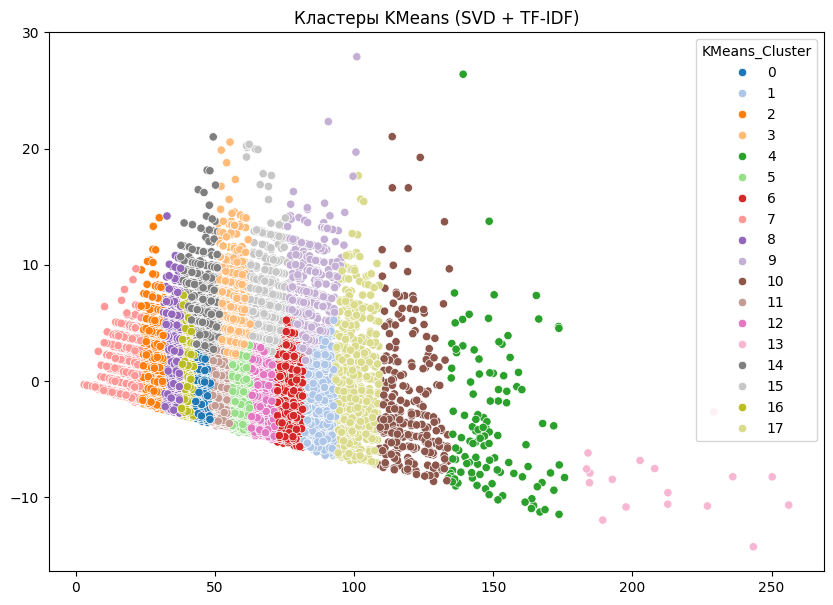

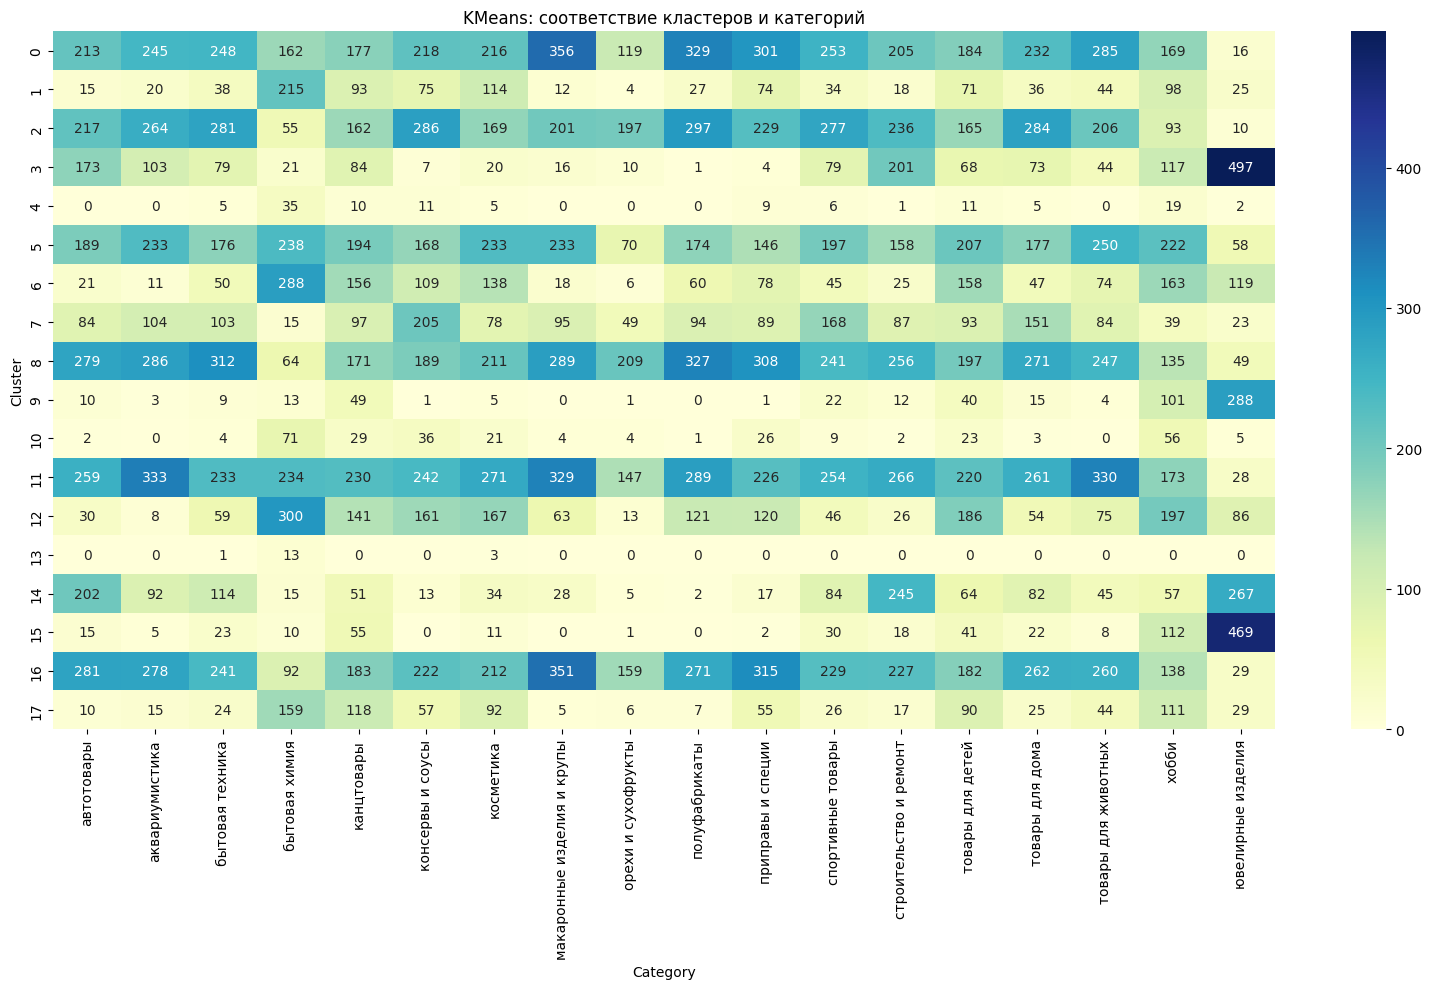

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

import nltk
import spacy

n_clusters = 18
brands = ['apple', 'bosch', 'lg', 'sony']
try:
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))
except LookupError:
    nltk.download('stopwords')
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))

stop_words_ru.update(['набор', 'фильтр', 'электрический'])

nlp = spacy.load("ru_core_news_sm")

def advanced_preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+[xх]\d+', '', text)
    text = re.sub(r'\b\d+(\.\d+)?\s?(мм|см|кг|л|мл)\b', '', text)
    text = re.sub(r'\b(?:' + '|'.join(brands) + r')\b', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)

    with nlp.select_pipes(disable=["ner", "parser"]):
        doc = nlp(text)
    return ' '.join([
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words_ru and
           token.lemma_ not in stop_words_en and
           len(token.lemma_) >= 3 and not token.is_stop
    ])

df = pd.read_csv("train_data.csv", on_bad_lines='skip')
df['Name'] = df['Name'].fillna('')
df['Category'] = df['Category'].fillna(df['Category'].mode()[0])

df['Processed_Name'] = df['Name'].apply(advanced_preprocess)

df['name_length'] = df['Name'].apply(len)
df['num_digits'] = df['Name'].apply(lambda x: len([c for c in x if c.isdigit()]))
df['num_words'] = df['Processed_Name'].apply(lambda x: len(x.split()))

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True
)
X_text = vectorizer.fit_transform(df['Processed_Name'])
X_numeric = df[['name_length', 'num_digits', 'num_words']].values
X = hstack([X_text, X_numeric])

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df['KMeans_Cluster'] = kmeans.fit_predict(X_svd)

true_labels = LabelEncoder().fit_transform(df['Category'])
silhouette_avg = silhouette_score(X_svd, df['KMeans_Cluster'])
ari = adjusted_rand_score(true_labels, df['KMeans_Cluster'])

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

os.makedirs("results", exist_ok=True)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=df['KMeans_Cluster'], palette='tab20', legend='full')
plt.title("Кластеры KMeans (SVD + TF-IDF)")
plt.savefig("results/svd_kmeans_clusters.png")
plt.show()

ct = pd.crosstab(df['KMeans_Cluster'], df['Category'])
plt.figure(figsize=(16, 10))
sns.heatmap(ct, cmap="YlGnBu", annot=True, fmt='d')
plt.title("KMeans: соответствие кластеров и категорий")
plt.ylabel("Cluster")
plt.xlabel("Category")
plt.tight_layout()
plt.savefig("results/kmeans_cluster_vs_category.png")
plt.show()

# Сам train

In [ ]:
import os
import re
import pickle
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


try:
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))
except LookupError:
    nltk.download('stopwords')
    stop_words_en = set(nltk.corpus.stopwords.words('english'))
    stop_words_ru = set(nltk.corpus.stopwords.words('russian'))

stop_words_ru.update(['набор', 'фильтр', 'электрический'])
brands = ['toyota', 'ford', 'mitsubishi', 'hyundai', 'audi', 'bmw', 'mercedes', 'apple', 'bosch', 'lg', 'sony']

nlp = spacy.load("ru_core_news_sm")

def advanced_preprocess(text):
    text = text.lower()

    text = re.sub(r'\d+[xх]\d+', '', text)

    text = re.sub(r'\b\d+(\.\d+)?\s?(мм|см|кг|л|мл)\b', '', text)

    brand_pattern = r'\b(?:' + '|'.join(brands) + r')\b'
    text = re.sub(brand_pattern, '', text)

    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    with nlp.select_pipes(disable=["ner", "parser"]):
        doc = nlp(text)


    return ' '.join([
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words_ru
        and token.lemma_ not in stop_words_en
        and len(token.lemma_) >= 3
        and not token.is_stop
    ])

data_path = os.path.join(os.path.dirname(__file__), "train_data.csv")
df = pd.read_csv(data_path, on_bad_lines='skip')

df['Name'] = df['Name'].fillna('')
df['Category'] = df['Category'].fillna(df['Category'].mode()[0])

df['Processed_Name'] = df['Name'].apply(advanced_preprocess)

df[['Processed_Name']].to_csv('processed_input.csv', index=False, header=False)

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 4),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    norm='l2'
)
X = vectorizer.fit_transform(df['Processed_Name'])

le = LabelEncoder()
y = le.fit_transform(df['Category'])

model = LogisticRegression(max_iter=1000, solver='liblinear')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(model, param_grid, cv=3)
grid.fit(X, y)

os.makedirs("models", exist_ok=True)

with open("models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Обучение завершено. Модель сохранена.")
print("Обработанный файл сохранён как 'processed_input.csv'")
print("Параметры обученной модели:")
print(grid.best_params_)
print("Тип векторизатора:", type(vectorizer))
print("Размер матрицы признаков:", X.shape)